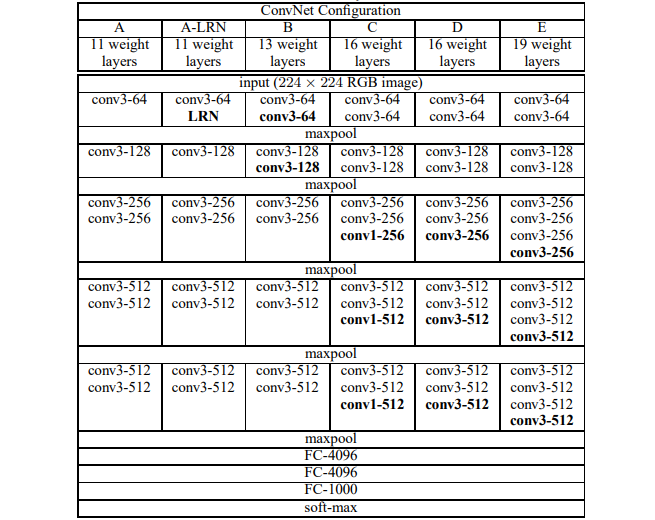

# VGG-16 구현을 위한 정리

## 1. Input
- 입력 크기: 224×224 RGB 이미지
- 전처리: 평균 RGB 값 빼기(mean subtraction)

## 2. Network Architecture
### Convolution Settings
- 모든 conv layer
  - 커널: 3×3
  - stride: 1
  - padding: 1 (same padding)
- 일부 1×1 conv 사용 가능 (VGG-16에서는 사실상 없음)
- Activation: ReLU
- LRN: 사용 안 함

### Pooling Settings
- max-pooling 적용 위치: 총 5번
- max-pooling 설정
  - 윈도우: 2×2
  - stride: 2



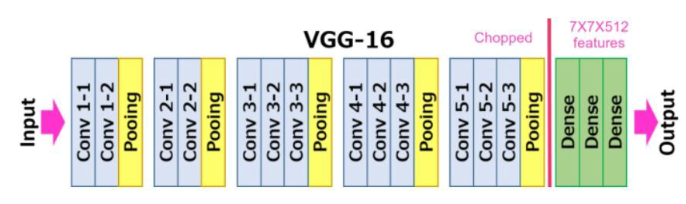

## 3. Training 설정
### Optimizer
- 방식: SGD
- Momentum: 0.9

### Loss
- Multinomial Logistic Regression (CrossEntropyLoss)

### Regularization
- Weight decay: 5×10⁻⁴
- Dropout: FC layer에 적용 (비율 0.5)

### Learning Rate Schedule
- 초기 learning rate: 0.01
- validation 성능이 plateau하면 10배 감소
- 총 3번 감소
- 전체 370,000 iterations (약 74 epochs)

### Batch Size
- 256

### Weight 초기화
- shallow한 네트워크 학습 후 transfer하거나,
- Glorot initialization 사용 가능

### Bias 초기화
- 전부 0

## 4. Data Augmentation
### Training
- 무작위 224×224 crop
- Random horizontal flip
- RGB 색상 변화(Random RGB shift)

### Training Scale
- Single Scale
  - S=256 또는
  - S=384 (fine-tuning시)
-Multi Scale (optional)
  - S ∈ [256, 512] 무작위 샘플링 (scale jittering)



## 5. Inference 설정
### Preprocessing
- 입력 이미지의 짧은 변을 Q 길이로 리사이즈
- crop 또는 dense evaluation

###Evaluation 방식
- Dense Evaluation
  - FC layer를 convolutional layer로 변환
  - Class score map을 spatial average
- Multi-crop Evaluation (Optional)
  - 5×5 grid crop + horizontal flip + 3 scales
- Test-time augmentation
  - Original + Horizontal Flip 결과 평균

In [24]:
import os
import zipfile
import requests
from tqdm import tqdm
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [19]:
def download_and_extract_tiny_imagenet(data_dir='tiny-imagenet-200'):
    import zipfile, requests
    from tqdm import tqdm

    url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
    zip_path = 'tiny-imagenet-200.zip'

    if not os.path.exists(data_dir):
        print("🔽 Downloading Tiny ImageNet...")
        with requests.get(url, stream=True) as r:
            with open(zip_path, 'wb') as f:
                for chunk in tqdm(r.iter_content(8192)):
                    f.write(chunk)

        print("📦 Extracting...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall()
        os.remove(zip_path)
        print("✅ Done.")

download_and_extract_tiny_imagenet()

🔽 Downloading Tiny ImageNet...


30286it [01:53, 267.42it/s]


📦 Extracting...
✅ Done.


In [20]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.480, 0.448, 0.398), (0.277, 0.269, 0.282))
])
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.480, 0.448, 0.398), (0.277, 0.269, 0.282))
])

In [21]:
# 전체 dataset
full_dataset = datasets.ImageFolder('tiny-imagenet-200/train', transform=train_transform)

total_len = len(full_dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len  # 나머지

train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

# val/test는 augmentation 없이
val_set.dataset.transform = test_transform
test_set.dataset.transform = test_transform

In [22]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True) # 논문에서는 256 batch size
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [26]:
import torch.nn as nn

class VGG16(nn.Module):
    def __init__(self, num_classes=200):
        super(VGG16, self).__init__()

        self.features = nn.Sequential(
            # Block 1: 224 x 224 x 64
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 112 x 112 x 64
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: 112 x 112 x 128
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 56 x 56 x 128
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: 56 x 56 x 256
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 28 x 28 x 256
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4: 28 x 28 x 512
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 14 x 14 x 512
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5: 14 x 14 x 512
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # 7 x 7 x 512
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=1e-2)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VGG16(num_classes=200).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"[Epoch {epoch+1}] Loss: {running_loss/len(train_loader):.4f}, Train Acc: {100.*correct/total:.2f}%")

    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * val_correct / val_total
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    scheduler.step(val_loss)

In [ ]:
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Acc: {100.*correct/total:.2f}%")